# **Customer churn forecast**

## Описание проекта

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.





### Описание услуг

**Оператор предоставляет два основных типа услуг:**

* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.

* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

**Также доступны такие услуги:**

* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
* За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

## План проекта

1. Исследовательский анализ данных
  * Загрузка данных
  * Предобработка данных
  * Анализ данных
2. Выбор модели
  * Выбор нескольких подходящих моделей
  * Создание примерных гиперпараметров
3. Подготовка данных
  * Преобразование в необходимую размерность
  * Преобразование в подходящий тип данных
  * Создание выборок
4. Обучение моделей
5. Проверка модели
  * Выбор метрик качества
  * Выбор наилучшей на основе кросс-валидации
  * Проверка лучшей модели на тестовой выборке

In [ ]:
%%bash
pip install ipywidgets phik shap --quiet
pip install catboost
pip install -U seaborn
pip install -U matplotlib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import re
import phik

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from ipywidgets import widgets, interact
from datetime import datetime
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 250923

## убрать экспонентациальные формы при выводе данных
pd.set_option('display.float_format', '{:,.2f}'.format)
# сбросим ограничение на количество выводимых столбцов, что бы просмотреть все столбцы
pd.set_option('display.max_columns', None)

## Исследовательский анализ данных

### Загрузка данных

In [ ]:
# Читаем данные из CSV-файлов
contract_new = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
personal_new = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
internet_new = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
phone_new = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

In [ ]:
# Для удобства объединим все таблицы в одну
df = contract_new.merge(personal_new, on='customerID', how='outer')
df = df.merge(internet_new, on='customerID', how='outer')
df = df.merge(phone_new, on='customerID', how='outer')

### Предобработка данных


In [ ]:
# Функция для преобразования "Camel сase" в "Snake case"
def camel_to_snake(name):
    name = re.sub('([A-Z]+)([A-Z][a-z])', r'\1_\2', name)
    name = re.sub('([a-z\d])([A-Z])', r'\1_\2', name)
    return name.lower()

In [ ]:
# Отображение первых 10 строк данных и получение общей информации о DataFrame
df.columns = [camel_to_snake(col) for col in df.columns]
display(df.head(10))
print(df.info())
print(df.isna().sum())

# Подсчет количества дубликатов и пропущенных значений в DataFrame
print('Количество дубликатов', sum(df.duplicated()))
print('Количество пропусков', sum(df.isna().sum()))

В таблице содержатся данные о 7043 пользователях. Дубликаты отсутствуют, однако необходимо сменить тип данных в столбцах TotalCharges, BeginDate, EndDate. Одинаковое количество пропусков (1526) для без интеренет-пользователей, вероятно для этой категории пользователей часть данных не собиралась. Есть 682 пропуска в столбце MultipleLines.

total_charges

In [ ]:
# Преобразование столбца 'total_charges' в числовой формат
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

# Заполнение пропущенных значений в столбце 'total_charges' нулями
df['total_charges'] = df['total_charges'].fillna(0.0)

end_date

In [ ]:
# Поскольку данные актуальны на 1 февраля 2020 года, заменим значения "No" в столбце "EndDate" на эту дату

df['end_date'] = df['end_date'].replace('No', '2020-02-01')
df['end_date'] = df['end_date'].astype('datetime64')

begin_date

In [ ]:
# Преобразуем столбец 'begin_date' в тип данных datetime64

df['begin_date'] = df['begin_date'].astype('datetime64')

multiple_lines

 Сделаем предположение, что для пользователей для которых пропущенны данные в столбце multiple_lines просто не подключены к нескольким линиям.
Заменим на 'No'.

In [ ]:
# Заполним пропущенные значения в столбце 'multiple_lines' значением 'No'

df['multiple_lines'] = df['multiple_lines'].fillna('No')

internet_service

In [ ]:
# Получим уникальные значения из столбца 'internet_service'

df['internet_service'].unique()

In [ ]:
# Гистограмма для визуализации выбора технологии интернета пользователями

plt.figure(figsize=(10, 1))
sns.histplot(y=df['internet_service'], bins=2, kde=False, color='#6A1A72')
plt.xlabel('Количество пользователей')
plt.ylabel('Технология')
plt.title('Выбор технологии пользователями', fontweight='bold')
plt.show()

In [ ]:
ratio = df.loc[df['internet_service'] == 'DSL'].shape[0] / df.shape[0]
df[df['internet_service'].isnull()][:int(df['internet_service'].isnull().sum()*ratio)].fillna('DSL', inplace=True)

df['internet_service'] = df['internet_service'].fillna('Fiber optic')

In [ ]:
# Пропущенные значения для интернет-пользователей заменим на 'No'

for column in list(df.columns):
    df[column] = df[column].fillna('No')

senior_citizen

In [ ]:
# Преобразование столбца 'senior_citizen' в тип 'object'

df['senior_citizen'] = df['senior_citizen'].astype('object')

### Выводы

In [ ]:
# Выводим информацию о DataFrame

df.info()

1. Загружены 4 датасета содержащие информацию о договорах, персональные данные клиентов, информации об интернет-услугах, информацию об услугах телефонии.
2. Таблицы объеденены в одну, образовавшиеся пропущенные значения были проанализированы и обработаны.
3. Значения в столбцах
  * end_date, begin_date приведены к типу datetime64[ns];
  * senior_citizen к типу object;
  * total_charges  к типу float64.

## Анализ данных

### Динамика заключения новых договоров

In [ ]:
xticks_min = pd.date_range(df.begin_date.min(), df.begin_date.max(), freq='M') - np.timedelta64(15,'D')
fig, ax = plt.subplots(figsize=(18, 4))

sns.histplot(data=df, x='begin_date', ax=ax, bins=mpl.dates.date2num(xticks_min), color='#6A1A72')
plt.title('Приток новых пользователей', fontsize=16, fontweight='bold')
ax.set(xlabel='Начало контракта', ylabel='Новые пользователи')
ax.set_xticks(ticks=xticks_min, labels=xticks_min.strftime('%b'), minor=True, rotation=45, fontsize=10)
plt.tick_params(pad=30)

In [ ]:
# Группировка данных по дате начала услуг и подсчет количества подключенных услуг

services = ['multiple_lines', 'online_security', 'online_backup', 'device_protection',
                'tech_support', 'streaming_tv', 'streaming_movies']
df_services = df.groupby('begin_date')[services].apply(lambda x: (x == 'Yes').sum())

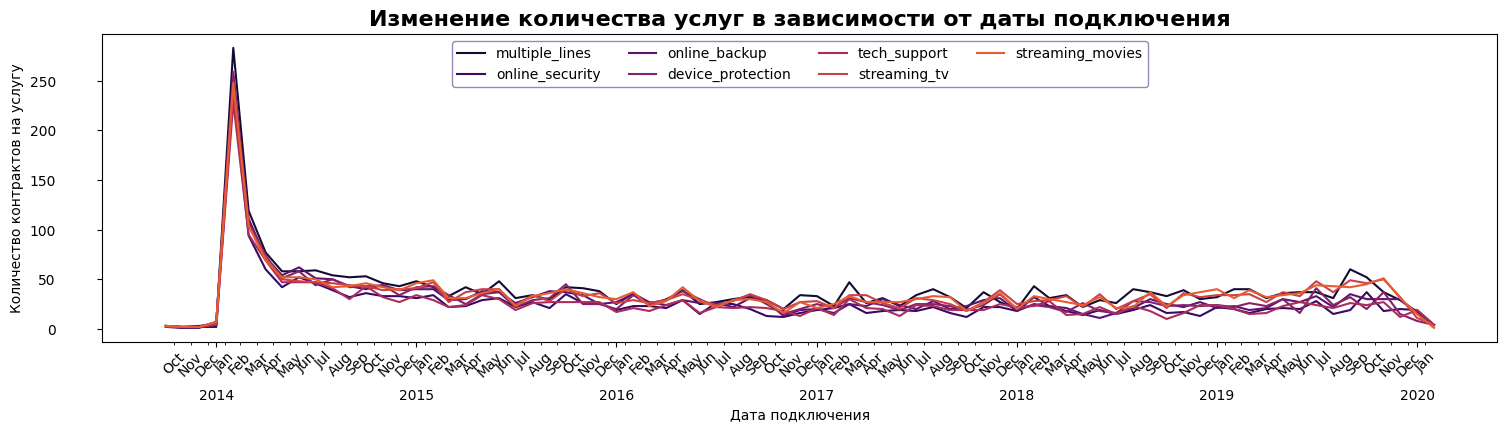

In [ ]:
# График изменения количества услуг в зависимости от даты подключения

fig, ax = plt.subplots(figsize=(18, 4))
sns.lineplot(data=df_services, estimator=None, ax=ax, dashes=False, palette=sns.color_palette('inferno', 10))
ax.set_title('Изменение количества услуг в зависимости от даты подключения', fontsize=16, fontweight='bold')
ax.set(xlabel='Дата подключения', ylabel='Количество контрактов на услугу')

xticks_min = pd.date_range(df_services.index.min(), df_services.index.max(), freq='M') - np.timedelta64(15,'D')
ax.set_xticks(ticks=xticks_min, labels=xticks_min.strftime('%b'), minor=True, rotation=45, fontsize=10)
ax.legend(services, edgecolor='#7B6DA5', loc='upper center', fontsize=10, ncol=4)
plt.tick_params(pad=30)

По графику видно, что в начале 2014 было заключено много новых контрактов. Вероятно, это связано с маркировкой всех более ранних контрактов этой датой.  С другой стороны это может быть связано с активной рекламной компанией. Спад активности в конце 2019 может быть связан с тем что новые данные не были внесены в базу.
Вероятно, имеет смысл удалить оба аномальных промежутка. Чтобы убедиться в этом, сначала посмотрим на количество данных и динамику оттока клиентов.

In [ ]:
# Рассмотрим стоит ли удалять периоды аномальной активности в 2014 и 2020 годах

print(f"Исключим {df[df['begin_date'] <= datetime(2014, 4, 1)].shape[0]} наблюдений в 2014-м году\n"
      f"Исключим {df[df['begin_date'] >= datetime(2019, 12, 1)].shape[0]} наблюдений в 2019-20x годах ")
new_df = df[(df['begin_date'] > datetime(2014, 4, 1)) & (df['begin_date'] < datetime(2019, 12, 1))].reset_index()
print(f"Всего потеряно {1-new_df.shape[0] / df.shape[0]:.2%} данных")

Исключим 673 наблюдений в 2014-м году
Исключим 464 наблюдений в 2019-20x годах 
Всего потеряно 16.14% данных


Более 15% данных - это много, не будем удалять.

### Отток клиентов

In [ ]:
# Создадим новый столбец churn в котором 0 - клиент остался, 1 - клиент ушел

df['churn'] = np.where(df['end_date'] < '2020-02-01', 1, 0)
df['churn'].unique()

array([0, 1])

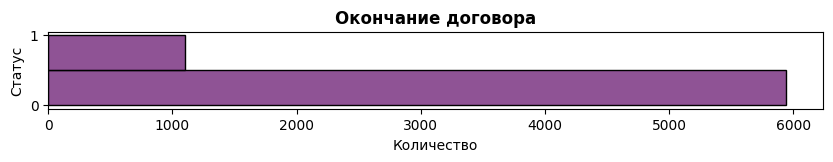

In [ ]:
# Рассмотрим соотношение пользователей

plt.figure(figsize=(10, 1))
sns.histplot(y=df['churn'], bins=2, kde=False, color='#6A1A72')
plt.xlabel('Количество')
plt.ylabel('Статус')
plt.title('Окончание договора', fontweight='bold')
plt.show()

На графике 0 - клиент остался, 1 - клиент ушел. Видно, что ушедших клиентов на много меньше и далее в работе надо будет это учитывать.

###  Cрок действия контракта

In [ ]:
df['tenure'] = (df['end_date'] - df['begin_date']) // np.timedelta64(1,'M')

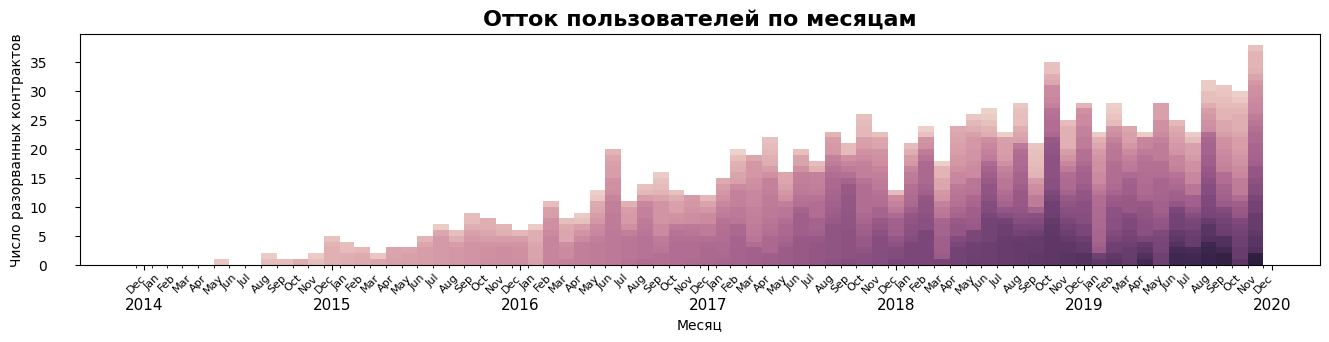

In [ ]:
data = df.loc[df['churn'] == 1]
n_months = (data['end_date'].max() - data['end_date'].min()) // np.timedelta64(1,'M')

xticks_maj = pd.date_range(data['begin_date'].min().strftime('%Y-%m'), data['end_date'].max(), freq='Y') + np.timedelta64(1,'D')
xticks_min = pd.date_range(data['begin_date'].min().strftime('%Y-%m'), data['end_date'].max(), freq='M') - np.timedelta64(15,'D')

plt.figure(figsize=(16,3))
ax = sns.histplot(data=data, x='end_date', bins=mpl.dates.date2num(xticks_min), hue='tenure',
                  multiple='stack', legend=False, alpha=1., linewidth=0)

ax.set(xlabel='Месяц', ylabel='Число разорванных контрактов')
ax.set_title('Отток пользователей по месяцам', fontsize=16, fontweight='bold')
ax.set_xticks(ticks=xticks_min, labels=xticks_min.strftime('%b'), minor=True, rotation=45, fontsize=8)
ax.set_xticks(ticks=xticks_maj, labels=xticks_maj.strftime('%Y'), fontsize=11)
plt.tick_params(pad=20)
plt.show()

Число разорванных контрактов становится все больше и больше. Самыми сложными месяцами являлись октябрь 2019 и ноябрь 2020. Вероятно эти всплески были связаны с какими-нибудь событиями в мире или, например,профилактическими работами.

### Распределение категориальных признаков для активных и ушедших клиентов

In [ ]:
# Группируем данные по целевому признаку
g = df.groupby(by='churn')
group_names = g.groups.keys()

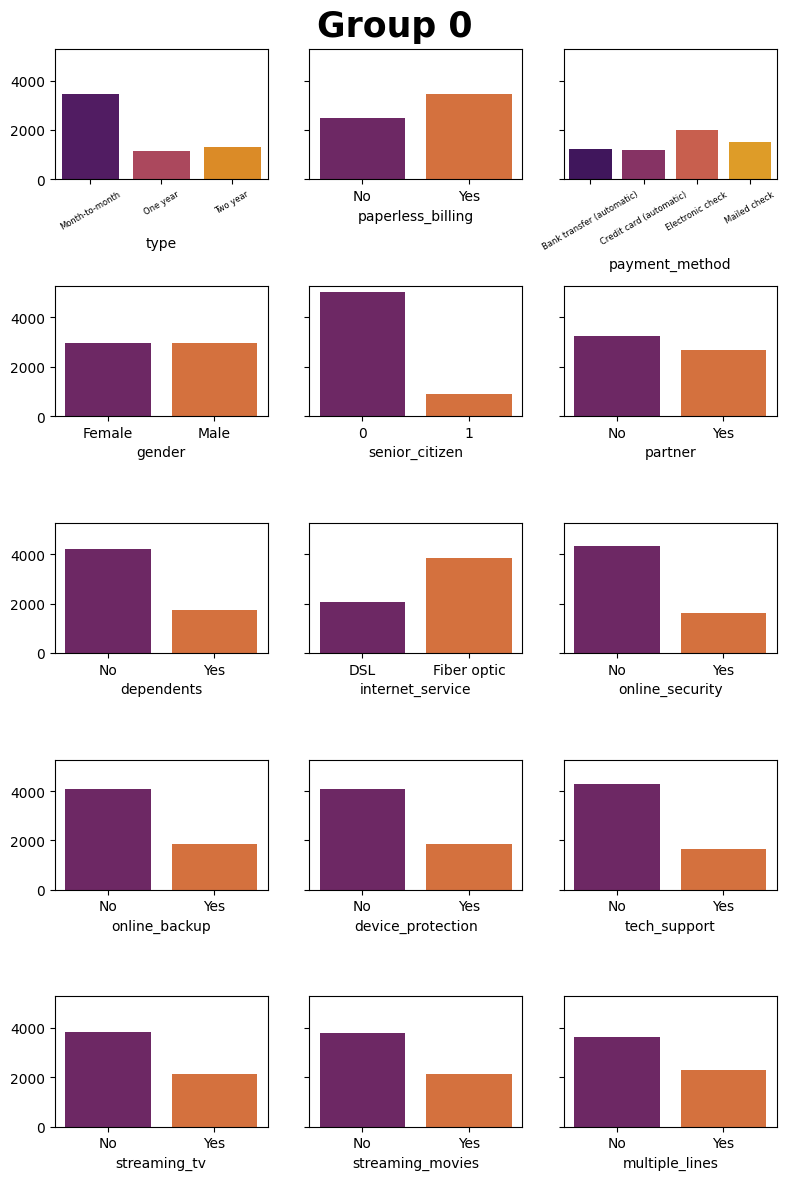

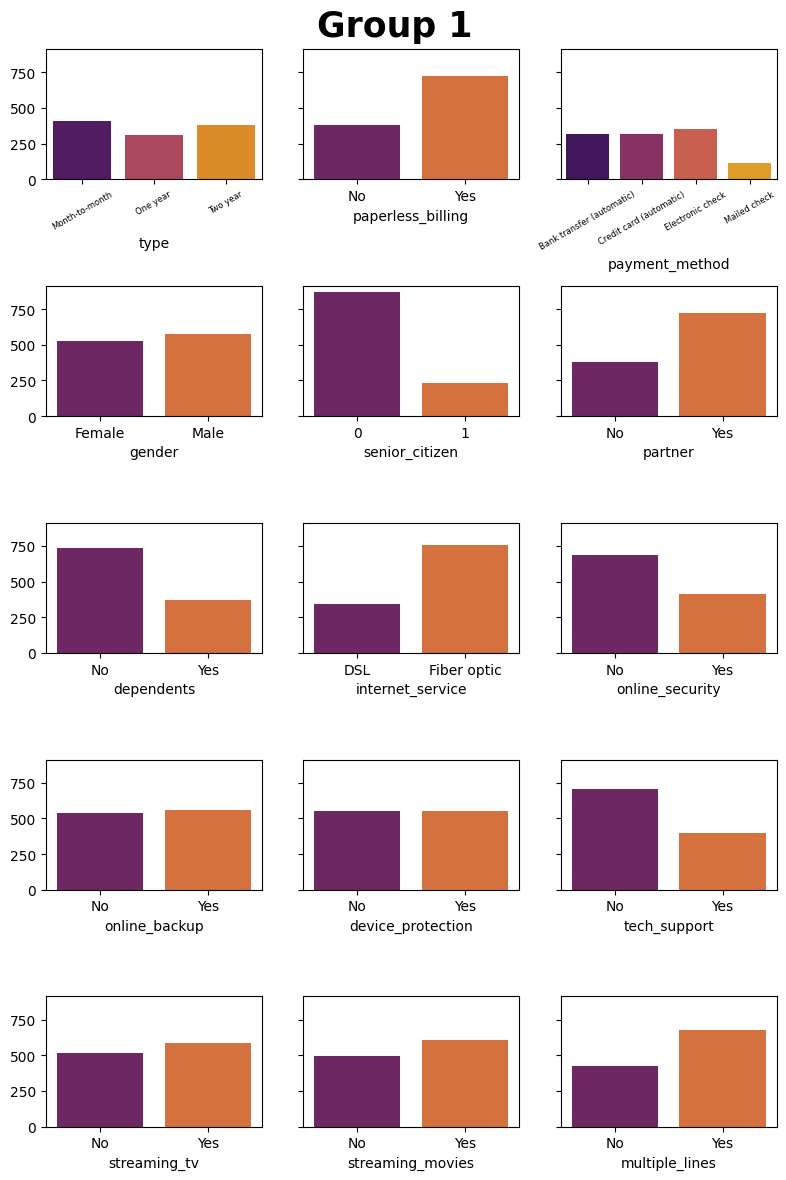

In [ ]:
for group_name in group_names:

    fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(8, 12), sharey=True)
    fig.suptitle(f'Group {group_name}', fontsize=25, fontweight='bold')


    group = g.get_group(group_name)

    # Выбираем только категориальные признаки
    gr_cat = group.drop(['customer_id', 'churn'], axis=1).select_dtypes('object')
    cat_cols = gr_cat.columns.to_list()

    # Отрисовываем графики для категориальных признаков
    for i in range(len(cat_cols)):
        ax = axs.ravel()[i]
        labels = group[cat_cols[i]].unique()
        labels.sort()
        sns.countplot(data=group, x=cat_cols[i], order=labels, ax=ax, palette='inferno')
        ax.set_ylabel(None)
        if len(ax.get_xticklabels()) > 2:
            ax.tick_params(axis='x', labelsize=6, rotation=30)

    fig.tight_layout()

plt.show()

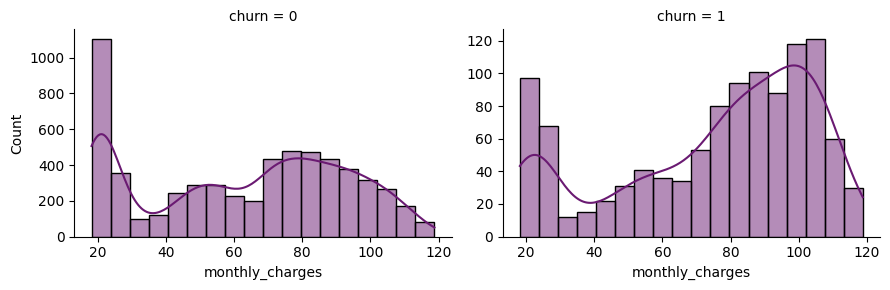

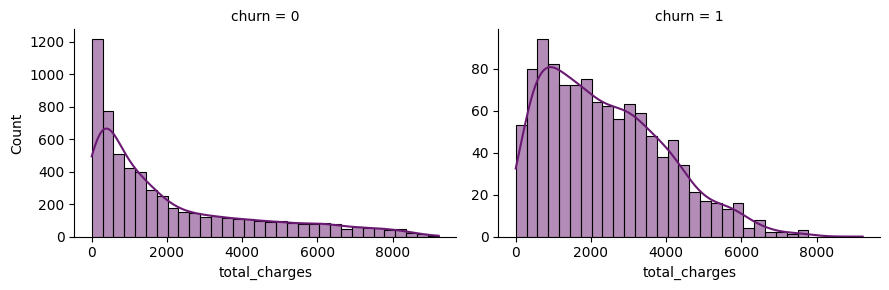

In [ ]:
# Распределение числовых признаков для df

sns.displot(data=df, x="monthly_charges", col="churn", kde=True, facet_kws={"sharey": False}, height=3, aspect=1.5, color='#6A1A72')
sns.displot(data=df, x="total_charges", col="churn", kde=True, facet_kws={"sharey": False}, height=3, aspect=1.5, color='#6A1A72');

 Среди ушедших клиентов есть значительный перевес в сторону высоких платежей.
Это объясняет повышенную долю пользователей дополнительных услуг (streaming_tv, streaming_movies, etc) среди ушедших клиентов.

### Анализ длительности контрактов

In [ ]:
data = df.sort_values('type')

def hist_interactive_bins(bins):
    plt.figure(figsize=(10, 5))
    plt.subplot(211)
    sns.histplot(data=data.loc[data['churn']== 0], x='tenure', bins=bins, hue='type', multiple="stack", kde=False, palette='inferno')
    plt.gca().set_title('Активные клиенты')
    plt.subplot(212)
    sns.histplot(data=data.loc[data['churn']== 1], x='tenure', bins=bins, hue='type', multiple="stack", kde=False, palette='inferno')
    plt.gca().set_title('Ушедшие клиенты')
    plt.gcf().tight_layout()
    plt.show()

bins = widgets.IntSlider(value=10, min=5, step=1, max=df['tenure'].max())
interact(hist_interactive_bins, bins=bins);

interactive(children=(IntSlider(value=10, description='bins', max=76, min=5), Output()), _dom_classes=('widget…

Разобьём пользователей на когорты по признаку monthly_payment:

* shrimps: < 30
* fish: 30-70
* dolphins: 70-90
* whales: > 90

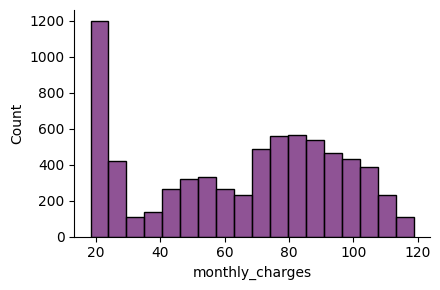

In [ ]:
sns.displot(data=df, x="monthly_charges", kde=False, height=3, aspect=1.5, color='#6A1A72');

In [ ]:
df['payer_class'] = None
df['payer_class'].loc[df['monthly_charges']<30] = 'shrimp'
df['payer_class'].loc[df['monthly_charges']>=30] = 'fish'
df['payer_class'].loc[df['monthly_charges']>=70] = 'dolphin'
df['payer_class'].loc[df['monthly_charges']>=90] = 'whale'

interval columns not set, guessing: ['tenure', 'total_charges', 'churn']


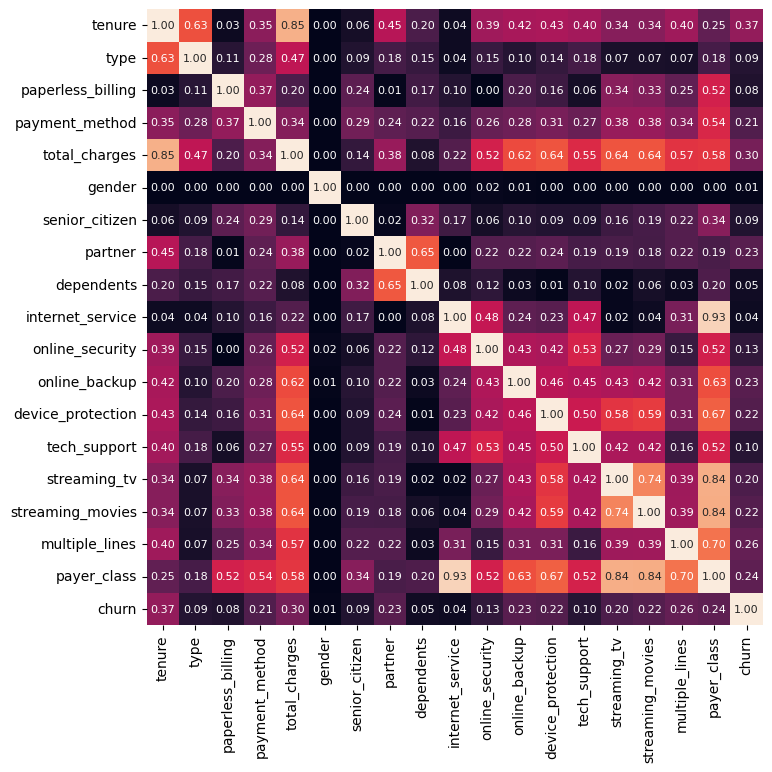

In [ ]:
# Рассмотрим корреляцию признаков

corr_matrix = df[['tenure', 'type', 'paperless_billing', 'payment_method',
       'total_charges', 'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines', 'payer_class', 'churn']].phik_matrix()
plt.figure(figsize=(8,8))
ax = sns.heatmap(data=corr_matrix, robust=True, vmin=0, vmax=1, annot=True, cbar=False,
                 square=True, fmt='.2f', annot_kws={'fontsize': 8})

In [ ]:
df[['payer_class', 'internet_service']].head(15)

,payer_class,internet_service
0,shrimp,DSL
1,fish,DSL
2,fish,DSL
3,fish,DSL
4,dolphin,Fiber optic
5,whale,Fiber optic
6,dolphin,Fiber optic
7,shrimp,DSL
8,whale,Fiber optic
9,fish,DSL


In [ ]:
df['tenure'] = (df['end_date'] - df['begin_date']) // np.timedelta64(1,'D')

### Выводы

Анализ данных показал что самая сильная корреляция между payer_class и internet_service. Если детально рассмотреть эти столбцы, то видно что большинство клиентов категории 'whale' пользуются технологией Fiber optic и, напротив, технологией DSL пользуются клиенты категорий 'fish' и 'shrimp'. Это логично, за более крутую технологию нужно больше платить.

А вот колонка gender не влияет ни на что, удалим ее.

## Выбор модели

Анализ оттока клиентов (customer churn analysis) является важной задачей для телекоммуникационных компаний и других бизнесов, предоставляющих услуги подписки. Для этой задачи часто используют следующие модели машинного обучения:

* Logistic Regression
* DecisionTreeClassifier
* RandomForestClassifier
* GradientBoostingClassifier
* CatBoostClassifier
* K-Nearest Neighbors
* XGBClassifier



## Подготовка данных

In [ ]:
X = df.drop(['churn', 'customer_id', 'end_date', 'begin_date', 'monthly_charges', 'gender'], axis = 1)
y = df['churn']

In [ ]:
#  Разделим набор данных на обучающий (X_train, y_train) и тестовый (X_test, y_test) наборы в соотношении 75% к 25%

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RANDOM_STATE, stratify=y)

In [ ]:
#  Разделим признаки на числовые и категориальные

numeric = ['total_charges','tenure']
categorical = [col for col in list(X.columns)
if col not in numeric and col != 'churn']

In [ ]:
# Создим два объекта Pipeline для предобработки числовых и категориальных признаков соответственно

num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))])

In [ ]:
# Создадим preprocessor, который объединит предобработку для числовых и категориальных признаков

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric),
        ('cat', cat_transformer, categorical)
    ])

## Обучение моделей

In [ ]:
# Функция возвращает лучшую настроенную модель (best_estimator_) и показатель ROC AUC (best_score_)

def param_tune(preprocessor, estimator, grid, X, y):
    model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', estimator)
    ])
    est_random = RandomizedSearchCV(estimator=model, param_distributions = grid,
                                    n_iter = 100, cv = 5, verbose=2, random_state=RANDOM_STATE,
                                    n_jobs = -1, scoring='roc_auc')
    est_random.fit(X, y)
    print(est_random.best_params_)
    return est_random.best_estimator_, est_random.best_score_

In [ ]:
result_table = pd.DataFrame(columns=['Mодель', 'ROC-AUC'])

### Logistic Regression

In [ ]:
grid_lr = {
    'classifier__C': [0.01, 0.05, 0.1, 0.5, 1],  # Обратная сила регуляризации
    'classifier__max_iter': [10, 25, 50, 75]  # Максимальное количество итераций
}

In [ ]:
model_lr, score_lr=param_tune(preprocessor, LogisticRegression(random_state=RANDOM_STATE, max_iter = 100), grid_lr, X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'classifier__max_iter': 25, 'classifier__C': 0.5}


In [ ]:
score_lr

0.7660470632869483

In [ ]:
result_table = result_table.append({'Mодель': 'Logistic Regression', 'ROC-AUC': score_lr}, ignore_index=True)

### DecisionTreeClassifier

In [ ]:
grid_dt = {'classifier__max_depth': range(1, 9), # максимальная глубина дерева решений
           'classifier__min_samples_leaf': range(4, 8), # минимальное количество выборок в листе дерева
           'classifier__min_samples_split': range(120, 150), # минимальное количество выборок для деления узла
           'classifier__criterion':['entropy', 'gini']} # функция для измерения качества разделения внутри узла

In [ ]:
model_dt, score_dt = param_tune(preprocessor, DecisionTreeClassifier(random_state=RANDOM_STATE), grid_dt, X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'classifier__min_samples_split': 132, 'classifier__min_samples_leaf': 5, 'classifier__max_depth': 6, 'classifier__criterion': 'gini'}


In [ ]:
score_dt

0.7986571302332595

In [ ]:
result_table = result_table.append({'Mодель': 'Decision tree', 'ROC-AUC': score_dt}, ignore_index=True)

### RandomForestClassifier

In [ ]:
grid_rf = {
    'classifier__n_estimators':range(80, 150), # количество деревьев в ансамбле случайного леса
    'classifier__max_depth': range(7, 14), # максимальная глубина каждого дерева в лесу
    'classifier__min_samples_split': range(7, 50) # минимальное количество выборок для деления узла
}

In [ ]:
model_rf, score_rf = param_tune(preprocessor, RandomForestClassifier(random_state=RANDOM_STATE), grid_rf, X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'classifier__n_estimators': 87, 'classifier__min_samples_split': 35, 'classifier__max_depth': 8}


In [ ]:
score_rf

0.8273894880591213

In [ ]:
result_table = result_table.append({'Mодель': 'Random Forest', 'ROC-AUC': score_rf}, ignore_index=True)

### GradientBoostingClassifier

In [ ]:
grid_gb = {
    'classifier__n_estimators' : range(80, 150),  # Количество деревьев
    'classifier__learning_rate' : [0.05, 0.1, 0.15],  # Скорость обучения
    'classifier__max_depth': [1,2,3],  # Максимальная глубина деревьев
    'classifier__min_samples_split': [4, 5, 6],  # Минимальное количество выборок для разделения узла
    'classifier__min_samples_leaf': [2, 3],  # Минимальное количество выборок в листе дерева
    'classifier__subsample': [0.1, 0.4, 0.8],  # Доля выборок для обучения каждого дерева
    'classifier__loss': ['deviance']  # Функция потерь
}

In [ ]:
model_gb, score_gb = param_tune(preprocessor, GradientBoostingClassifier(), grid_gb, X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'classifier__subsample': 0.8, 'classifier__n_estimators': 143, 'classifier__min_samples_split': 6, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 3, 'classifier__loss': 'deviance', 'classifier__learning_rate': 0.15}


In [ ]:
score_gb

0.8838048536745866

In [ ]:
result_table = result_table.append({'Mодель': 'Gradient Boosting', 'ROC-AUC': score_gb}, ignore_index=True)

### CatBoostClassifier

In [ ]:
grid_cb = {
    'classifier__n_estimators': [180, 200, 220],  # Количество деревьев
    'classifier__learning_rate': [0.2, 0.25, 0.3],  # Скорость обучения
    'classifier__max_depth': [2, 3, 4],  # Максимальная глубина деревьев
}

In [ ]:
model_cb, score_cb = param_tune(preprocessor, CatBoostClassifier(), grid_cb, X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
0:	learn: 0.4988561	total: 48.5ms	remaining: 10.6s
1:	learn: 0.4196594	total: 50.7ms	remaining: 5.53s
2:	learn: 0.3868802	total: 52.6ms	remaining: 3.81s
3:	learn: 0.3649970	total: 54.5ms	remaining: 2.94s
4:	learn: 0.3580493	total: 56.7ms	remaining: 2.44s
5:	learn: 0.3468332	total: 58.8ms	remaining: 2.1s
6:	learn: 0.3389592	total: 61ms	remaining: 1.85s
7:	learn: 0.3335804	total: 63.3ms	remaining: 1.68s
8:	learn: 0.3298993	total: 65.4ms	remaining: 1.53s
9:	learn: 0.3269785	total: 67.6ms	remaining: 1.42s
10:	learn: 0.3253277	total: 69.7ms	remaining: 1.32s
11:	learn: 0.3233492	total: 71.9ms	remaining: 1.25s
12:	learn: 0.3219527	total: 74.1ms	remaining: 1.18s
13:	learn: 0.3204350	total: 76ms	remaining: 1.12s
14:	learn: 0.3188871	total: 78.1ms	remaining: 1.07s
15:	learn: 0.3175308	total: 80.3ms	remaining: 1.02s
16:	learn: 0.3159925	total: 82.4ms	remaining: 984ms
17:	learn: 0.3135519	total: 84.6ms	remaining: 949ms
18:	learn: 0.3120

In [ ]:
score_cb

0.9248994080661775

In [ ]:
result_table = result_table.append({'Mодель': 'CatBoostClassifier', 'ROC-AUC': score_cb}, ignore_index=True)

### K-Nearest Neighbors

In [ ]:
grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],  # Количество соседей
    'classifier__weights': ['uniform', 'distance'],  # Веса соседей
    'classifier__p': [1, 2]  # Параметр метрики расстояния (1 - манхэттенское расстояние, 2 - евклидово расстояние)
}

In [ ]:
model_knn, score_knn = param_tune(preprocessor, KNeighborsClassifier(), grid_knn, X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'classifier__weights': 'uniform', 'classifier__p': 2, 'classifier__n_neighbors': 7}


In [ ]:
score_knn

0.7471102619565556

In [ ]:
result_table = result_table.append({'Mодель': 'K-Nearest Neighbors', 'ROC-AUC': score_knn}, ignore_index=True)

### XGBClassifier

In [ ]:
grid_xgb = {
    'classifier__n_estimators': range(120, 180),  # Количество деревьев
    'classifier__max_depth': [1, 2, 3],  # Максимальная глубина деревьев
    'classifier__learning_rate': [0.2, 0.3],  # Скорость обучения (learning rate)
    'classifier__subsample': [0.8, 0.9, 1.0],  # Доля случайной подвыборки обучающих данных
    'classifier__colsample_bytree': [0.8, 0.9, 1.0],  # Доля случайных признаков для построения каждого дерева
}

In [ ]:
model_xgb, score_xgb = param_tune(preprocessor, XGBClassifier(), grid_xgb, X_train, y_train)

In [ ]:
score_xgb

0.9142009944994187

In [ ]:
result_table = result_table.append({'Mодель': 'XGBClassifier', 'ROC-AUC': score_xgb}, ignore_index=True)

### Выводы

In [ ]:
result_table

,Mодель,ROC-AUC
0,Logistic Regression,0.77
1,Decision tree,0.80
2,Random Forest,0.83
3,Gradient Boosting,0.88
4,CatBoostClassifier,0.92
5,K-Nearest Neighbors,0.75
6,XGBClassifier,0.91


 CatBoost Classifier показал наилучший результат. Будем тестировать!

## Проверка модели

In [ ]:
    y_pred = model_cb.predict(X_test)
    roc_auc = roc_auc_score(y_pred, y_test)

    print(f'CatBoostClassifier ROC-AUC: {roc_auc}')

CatBoostClassifier ROC-AUC: 0.905596545212952


 CatBoost Classifier показал наилучший результат 0.91 на тестовой выборке.

In [ ]:
y_pred = model_cb.predict(X_test)

conf_matr_cb = confusion_matrix(y_test, y_pred)

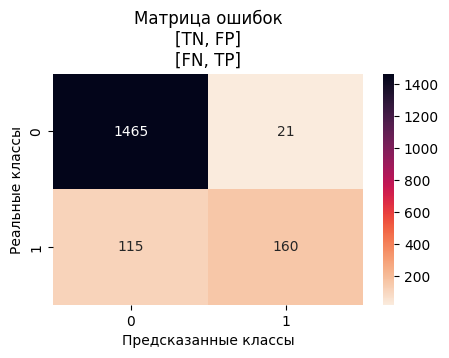

In [ ]:
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matr_cb, annot=True, cmap='rocket_r', fmt='g')
plt.title(f'Матрица ошибок\n[TN, FP]\n[FN, TP]')
plt.xlabel('Предсказанные классы')
plt.ylabel('Реальные классы');

* Модель верно предсказала оставшихся клиентов (класс 0) - 1465 раза
* Модель ошиблась в предсказании оставшихся клиентов (класс 0) - 21 раза
* Модель верно предсказала ушедших клиентов (класс 1) - 160 раз
* Модель ошиблась в предсказании ушедших клиентов (класс 1) - 115 раз

## Рассмотрим вклада признаков в предстазание

In [ ]:
importances = model_cb[1].feature_importances_

In [ ]:
ohe = model_cb.named_steps['preprocessor'].named_transformers_['cat']

In [ ]:
feature_names_cat = ohe.get_feature_names_out(input_features=categorical)

In [ ]:
feature_names = list(numeric) + list(feature_names_cat)

In [ ]:
plt.figure(figsize=(10, 10))
sns.barplot(x=importances, y=feature_names, palette='inferno')
plt.title('Влияние признаков', fontweight='bold')
plt.tick_params(pad=10)
plt.show()

Можно заметить, что признак tenure является самым значимым для модели. Так же признак total charges достаточно сильно влияет на модель.

### Выводы
Выявили и  проверили на тестовых данных лучшую модель (Random Forest Classifier) полученую ходе подбора через RandomizedSearchCV.
Модель показала метрики ROC-AUC - 0.87.
Исследовали важность признаков модели, оказалось что признак tenure является самым значимым для модели. Так же признак total charges достаточно сильно влияет на модель.



## Выводы


Мы решали задачу, которая заключалась в разработке модели машинного обучения для оператора связи "Ниединогоразрыва.ком". Эта компания стремится создать модель, которая помогла бы выявлять клиентов, которые могут решить перейти к другому оператору, с целью предлагать им специальные промокоды и условия. Главная цель заказчика заключается в том, чтобы удерживать своих текущих клиентов и увеличивать прибыль за счет этого.

Был проведен исследовательский анализ данных:
1. Загружены 4 датасета содержащие информацию о договорах, персональные данные клиентов, информации об интернет-услугах, информацию об услугах телефонии.
2. Таблицы объеденены в одну, образовавшиеся пропущенные значения были проанализированы и обработаны.
3. Значения в столбцах
  * end_date, begin_date приведены к типу datetime64[ns];
  * senior_citizen к типу object;
  * total_charges  к типу float64.
4. Созданы новые признаки
  * chern - ушел ли пользователь
  * tenere - длительность контракта
  * monthly_payment - сгруппировали по monthly_charges на 4 кагорты.
5. Проведен анализ данных
* Оказалось, что в начале 2014 было заключено много новых контрактов и обнаружен спад активности в конце 2019.
* Обнаружено что ушедших клиентов на много меньше.
* было показано, что число разорванных контрактов увеличивается со временем. Самыми сложными месяцами являлись октябрь 2019 и ноябрь 2020.
* рассмотрено распределение числовых и категориальных признаков для активных и ушедших клиентов.
Оказалось, что среди ушедших клиентов есть значительный перевес в сторону высоких платежей. Это объясняет повышенную долю пользователей дополнительных услуг (streaming_tv, streaming_movies, etc) среди ушедших клиентов.
* Анализ данных показал что самая сильная корреляция между payer_class и internet_service. Если детально рассмотреть эти столбцы, то видно что большинство клиентов категории 'whale' пользуются технологией Fiber optic и, напротив, технологией DSL пользуются клиенты категорий 'fish' и 'shrimp'. Это логично, за более крутую технологию нужно больше платить. А вот колонка gender не влияет ни на что, удалим ее.


Были выбран ряд моделей для обучения (Logistic Regression, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, CatBoostClassifier, K-Nearest Neighbors, XGBClassifier) и в соответствии с этим проведеа соответствующая обработка данных, а именно масштабирование числовых и  кодирование категориальных признаков.

Модели были обучены, гиперпараметры подбирались с помощью RandomizedSearchCV. Качество моделей оценивали по метрике ROC-AUC. Random Forest Classifier, Gradient Boosting Classifier, CatBoost Classifier, XGBoost Classifier показали знпчение метрики ROC-AUC больше 0.8. Так как значения очень похожи, все они были проверены  на тестовой выборке.



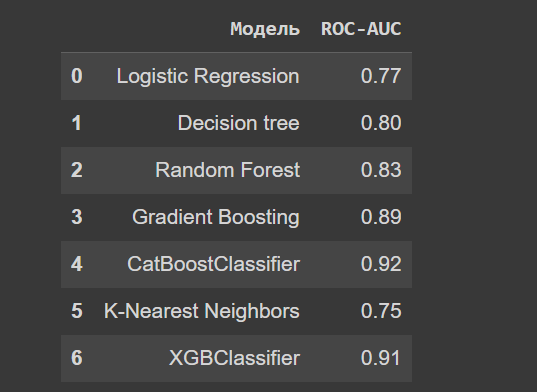

Random Forest CatBoost Classifier показал наилучший результат 0.91 на тестовой выборке. Модель предсказала TN - 1465 раза,
FP - 21 раза, FN - 115 раз, TP - 160 раза.

Было изучено влияние признаком на предсказаня модели. Оказалось, что признак tenure является самым значимым для модели. Так же признак total charges достаточно сильно влияет на модель.


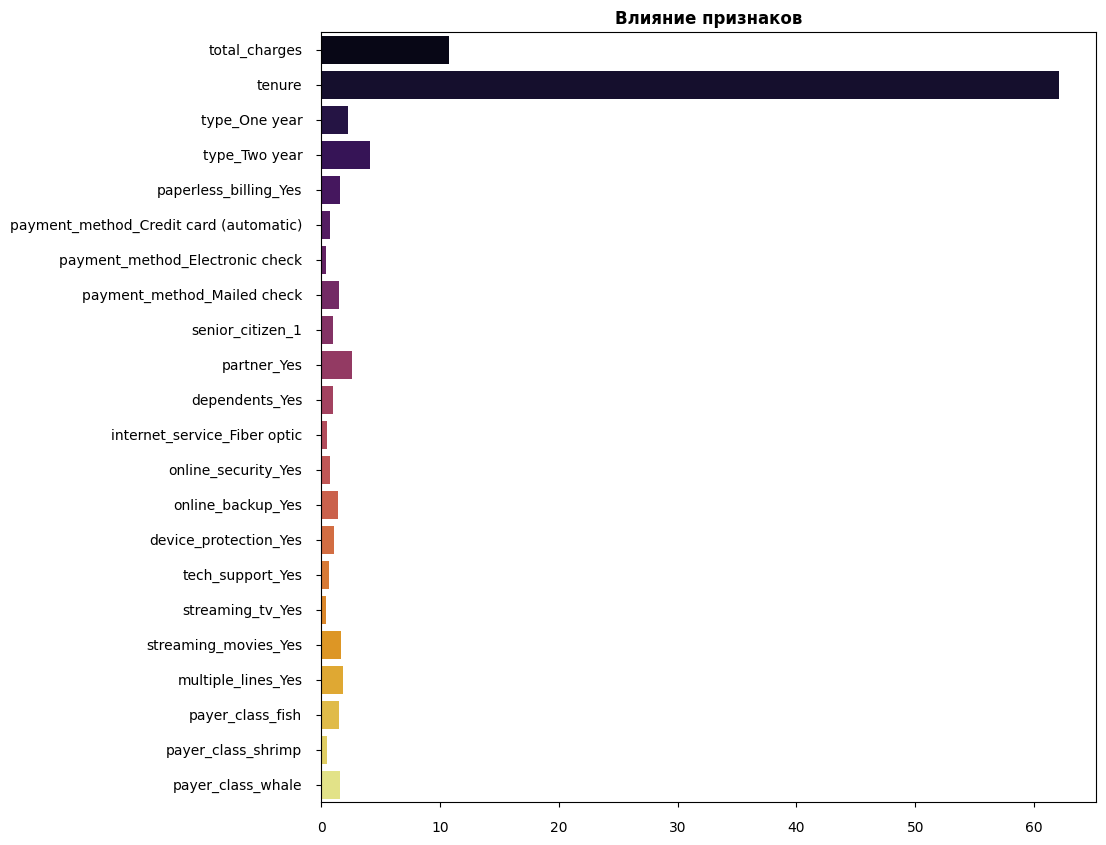